In [14]:
import numpy as np
import matplotlib.pyplot as plt
import qnmfits
import funcs.CCE as CCE
from funcs.likelihood_funcs import *
from funcs.GP_funcs import *
from funcs.utils import * 
from funcs.kernel_param_funcs import * 
import corner
import scipy
import pickle

from scipy.interpolate import InterpolatedUnivariateSpline as spline

In [4]:
with open("residual_sim_dict.pkl", "rb") as f:
    residual_sim_dict = pickle.load(f)

In [15]:
id = "0001"
DT = 0.5

sim_main = CCE.SXS_CCE(id, lev="Lev5", radius="R2")
new_times = np.arange(sim_main.times[0], sim_main.times[-1], DT)
sim_main = sim_interpolator(sim_main, new_times)

In [16]:
l_max = 4
n_max = 5

t0 = 0
T = 50

analysis_mask = (sim_main.times >= t0 - 1e-9) & (sim_main.times < t0 + T)
analysis_times = sim_main.times[analysis_mask]

qnm_list = [
    (ell, 2, n, 1) for ell in np.arange(2, l_max + 1) for n in np.arange(0, n_max + 1)
]
spherical_modes = [(ell, 2) for ell in np.arange(2, l_max + 1)]

# qnm_list = [(ell,m,n,p) for ell in np.arange(2, l_max+1) for m in np.arange(-ell, ell+1) for n in np.arange(0, n_max+1) for p in [-1,1]]
# spherical_modes = [(ell, m) for ell in np.arange(2, l_max+1) for m in np.arange(-ell, ell+1)]

chif_mag_0 = sim_main.chif_mag
Mf_0 = sim_main.Mf

In [17]:
param_list = [qnm for qnm in qnm_list for _ in range(2)]

ls_fit = qnmfits.multimode_ringdown_fit(
    sim_main.times,
    sim_main.h,
    modes=qnm_list,
    Mf=Mf_0,
    chif=chif_mag_0,
    t0=t0,
    T=T,
    spherical_modes=spherical_modes,
)

ls_c = ls_fit["C"]

true_as = []
for re_c, im_c in zip(np.real(ls_fit["C"]), np.imag(ls_fit["C"])):
    true_as.append(re_c)
    true_as.append(im_c)

true_params = true_as

In [18]:
residual_amplitudes = {}

for ell, m in residual_sim_dict[id].keys():
    residual_amplitudes[(ell, m)] = np.max(
        np.abs(residual_sim_dict[id][ell, m][analysis_mask])
    )

In [19]:
with open("param_dict_sim_lm_full.pkl", "rb") as f:
    param_dict_sim_lm = pickle.load(f)

with open("f_dict_sim_lm_full.pkl", "rb") as f:
    f_dict_sim_lm = pickle.load(f)

tuning_hyperparams_s = [0.4011230468749995]
tuning_hyperparams = [
    1.321358102430008,
    -0.01345115218261082,
    4.093379916592142,
    0.5113668268176057,
]
# tuning_hyperparams = [1, 1, 1, 1]
tuning_hyperparams_c = [
    1.316402500108596,
    0.4326335562654318,
    -0.13408450413327633,
    4.039978781750003,
    0.1971672415404262,
    4.933667981055878,
    4.969654116813137,
    -0.35133507763297867,
]
# tuning_hyperparams_c = [1.321358102430008, -0.01345115218261082, 4.093379916592142, 0.5113668268176057]

hyperparam_rule_dict_s = {
    "sigma_max": "multiply",
}

hyperparam_rule_dict = {
    "sigma_max": "multiply",
    "t_s": "sum",
    "length_scale": "multiply",
    "period": "multiply",
}

hyperparam_rule_dict_c = {
    "sigma_max": "multiply",
    "t_s": "sum",
    "sharpness": "sum",
    "length_scale": "multiply",
    "period": "multiply",
    "length_scale_2": "multiply",
    "period_2": "multiply",
    "a": "sum",
}

tuned_param_dict_s = {}
tuned_param_dict = {}
tuned_param_dict_c = {}

for mode in param_dict_sim_lm[id].keys():
    tuned_param_dict_s[mode] = get_new_params(
        param_dict_sim_lm[id][mode], tuning_hyperparams_s, hyperparam_rule_dict_s
    )
    tuned_param_dict[mode] = get_new_params(
        param_dict_sim_lm[id][mode], tuning_hyperparams, hyperparam_rule_dict
    )
    tuned_param_dict_c[mode] = get_new_params(
        param_dict_sim_lm[id][mode], tuning_hyperparams_c, hyperparam_rule_dict_c
    )

In [20]:
print(
    get_total_log_evidence(
        tuning_hyperparams_s,
        param_dict_sim_lm,
        f_dict_sim_lm,
        hyperparam_rule_dict_s,
        analysis_times,
        kernel_s,
    )
)
print(
    get_total_log_evidence(
        tuning_hyperparams,
        param_dict_sim_lm,
        f_dict_sim_lm,
        hyperparam_rule_dict,
        analysis_times,
        kernel,
    )
)
print(
    get_total_log_evidence(
        tuning_hyperparams_c,
        param_dict_sim_lm,
        f_dict_sim_lm,
        hyperparam_rule_dict_c,
        analysis_times,
        kernel_c,
    )
)

TypeError: get_total_log_evidence() missing 2 required positional arguments: 'spherical_modes' and 'mode_rules'

In [ ]:
n_times = len(analysis_times)

kernel_dict_s = {}

for ell, m in spherical_modes:
    kernel_dict_s[(ell, m)] = (
        kernel_s(np.asarray(analysis_times), **tuned_param_dict_s[ell, m])
        + np.eye(len(analysis_times)) * 1e-12
    )

kernel_dict = {}

for ell, m in spherical_modes:
    kernel_dict[(ell, m)] = (
        kernel(np.asarray(analysis_times), **tuned_param_dict[ell, m])
        + np.eye(len(analysis_times)) * 1e-12
    )

kernel_dict_c = {}

for ell, m in spherical_modes:
    kernel_dict_c[(ell, m)] = (
        kernel_c(np.asarray(analysis_times), **tuned_param_dict_c[ell, m])
        + np.eye(len(analysis_times)) * 1e-12
    )

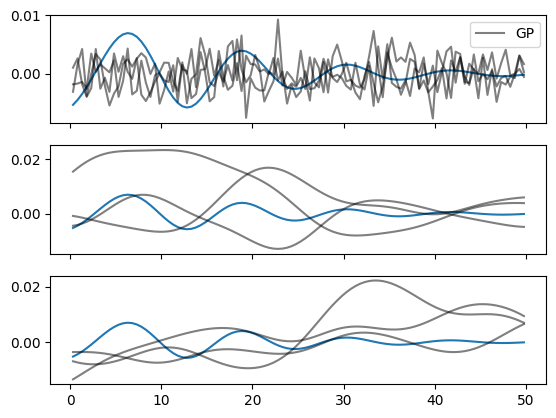

In [ ]:
rng = np.random.default_rng()

fig, axs = plt.subplots(3, 1, sharex=True)

ell, m = (2, 2)

axs[0].plot(
    sim_main.times[analysis_mask], np.real(residual_sim_dict[id][ell, m])[analysis_mask]
)
axs[1].plot(
    sim_main.times[analysis_mask], np.real(residual_sim_dict[id][ell, m])[analysis_mask]
)
axs[2].plot(
    sim_main.times[analysis_mask], np.real(residual_sim_dict[id][ell, m])[analysis_mask]
)

repeats = 3

gp_samples_s = rng.multivariate_normal(
    np.zeros(n_times), kernel_dict_s[ell, m], size=repeats
)
gp_samples = rng.multivariate_normal(
    np.zeros(n_times), kernel_dict[ell, m], size=repeats
)
gp_samples_c = rng.multivariate_normal(
    np.zeros(n_times), kernel_dict_c[ell, m], size=repeats
)

for j, draw in enumerate(gp_samples_s):
    label = "GP" if j == 0 else None
    axs[0].plot(analysis_times, draw, color="black", alpha=0.5, label=label)

for j, draw in enumerate(gp_samples):
    label = "GP" if j == 0 else None
    axs[1].plot(analysis_times, draw, color="black", alpha=0.5, label=label)

for j, draw in enumerate(gp_samples_c):
    label = "GP" if j == 0 else None
    axs[2].plot(analysis_times, draw, color="black", alpha=0.5, label=label)

axs[0].legend()

In [ ]:
fig_width = 246.0 * (1.0 / 72.27)
fig_height = fig_width / 1.618

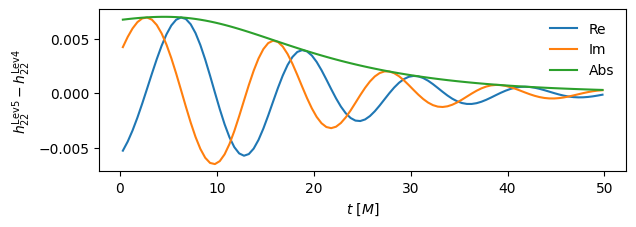

In [ ]:
fig, ax = plt.subplots(figsize=(fig_width * 2, fig_height))

ax.plot(analysis_times, np.real(f_dict_sim_lm[id][2, 2]), label="Re")
ax.plot(analysis_times, np.imag(f_dict_sim_lm[id][2, 2]), label="Im")
ax.plot(analysis_times, np.abs(f_dict_sim_lm[id][2, 2]), label="Abs")

ax.set_ylabel(r"$h_{22}^\mathrm{Lev5} - h_{22}^\mathrm{Lev4}$")
ax.set_xlabel("$t \,\, [M]$")
ax.legend(frameon=False)

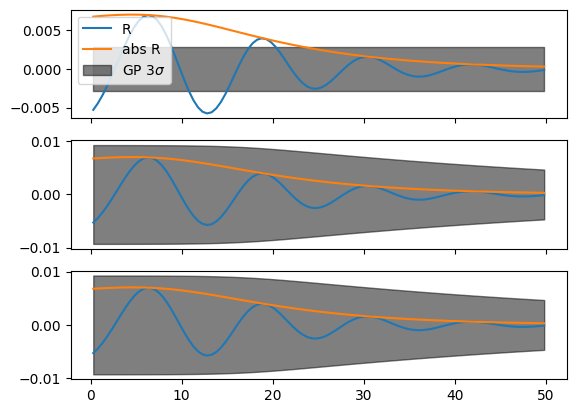

In [ ]:
fig, axs = plt.subplots(3, 1, sharex=True)

axs[0].plot(
    sim_main.times[analysis_mask],
    np.real(residual_sim_dict[id][ell, m])[analysis_mask],
    label="R",
)
axs[1].plot(
    sim_main.times[analysis_mask],
    np.real(residual_sim_dict[id][ell, m])[analysis_mask],
    label="R",
)
axs[2].plot(
    sim_main.times[analysis_mask],
    np.real(residual_sim_dict[id][ell, m])[analysis_mask],
    label="R",
)

axs[0].plot(
    sim_main.times[analysis_mask],
    np.abs(residual_sim_dict[id][ell, m])[analysis_mask],
    label="abs R",
)
axs[1].plot(
    sim_main.times[analysis_mask],
    np.abs(residual_sim_dict[id][ell, m])[analysis_mask],
    label="abs R",
)
axs[2].plot(
    sim_main.times[analysis_mask],
    np.abs(residual_sim_dict[id][ell, m])[analysis_mask],
    label="abs R",
)

period_length = param_dict_sim_lm[id][(ell, m)]["period"]

# axs[i].plot([40, 40+period_length], [np.min(np.real(R[ell, m])[analysis_mask]), np.min(np.real(R[ell, m])[analysis_mask])], 'k-', lw=1)
# axs[i].plot([40, 40], [np.min(np.real(R[ell, m])[analysis_mask]) - 0.05 * np.ptp(np.real(R[ell, m])[analysis_mask]), np.min(np.real(R[ell, m])[analysis_mask]) + 0.05 * np.ptp(np.real(R[ell, m])[analysis_mask])], 'k-', lw=1)
# axs[i].plot([40+period_length, 40+period_length], [np.min(np.real(R[ell, m])[analysis_mask]) - 0.05 * np.ptp(np.real(R[ell, m])[analysis_mask]), np.min(np.real(R[ell, m])[analysis_mask]) + 0.05 * np.ptp(np.real(R[ell, m])[analysis_mask])], 'k-', lw=1)
# axs[i].text(40 + period_length / 2, np.min(np.real(R[ell, m])[analysis_mask]) - 0.25 * np.ptp(np.real(R[ell, m])[analysis_mask]), r'$P^{\beta}_i$', ha='center')

# Plot the 1-sigma credible region of the GP
axs[0].fill_between(
    analysis_times,
    -np.sqrt(np.diag(kernel_dict_s[ell, m])),
    np.sqrt(np.diag(kernel_dict_s[ell, m])),
    color="black",
    alpha=0.5,
    label="GP 3$\sigma$",
)

axs[1].fill_between(
    analysis_times,
    -np.sqrt(np.diag(kernel_dict[ell, m])),
    np.sqrt(np.diag(kernel_dict[ell, m])),
    color="black",
    alpha=0.5,
    label="GP 3$\sigma$",
)

axs[2].fill_between(
    analysis_times,
    -np.sqrt(np.diag(kernel_dict_c[ell, m])),
    np.sqrt(np.diag(kernel_dict_c[ell, m])),
    color="black",
    alpha=0.5,
    label="GP 3$\sigma$",
)

axs[0].legend()

In [ ]:
kernel_dict_inv_s = {
    (ell, m): np.linalg.inv(kernel_dict_s[ell, m]) for ell, m in spherical_modes
}
kernel_dict_inv = {
    (ell, m): np.linalg.inv(kernel_dict[ell, m]) for ell, m in spherical_modes
}
kernel_dict_inv_c = {
    (ell, m): np.linalg.inv(kernel_dict_c[ell, m]) for ell, m in spherical_modes
}

# Convert kernel_dict_inv to a matrix
kernel_matrix_inv_s = np.zeros(
    (len(spherical_modes), n_times, n_times), dtype=np.complex128
)
kernel_matrix_inv = np.zeros(
    (len(spherical_modes), n_times, n_times), dtype=np.complex128
)
kernel_matrix_inv_c = np.zeros(
    (len(spherical_modes), n_times, n_times), dtype=np.complex128
)

for idx, (ell, m) in enumerate(spherical_modes):
    kernel_matrix_inv_s[idx, :, :] = kernel_dict_inv_s[(ell, m)]

for idx, (ell, m) in enumerate(spherical_modes):
    kernel_matrix_inv[idx, :, :] = kernel_dict_inv[(ell, m)]

for idx, (ell, m) in enumerate(spherical_modes):
    kernel_matrix_inv_c[idx, :, :] = kernel_dict_inv_c[(ell, m)]

In [ ]:
fisher_matrix_s = get_fisher_matrix(
    qnm_list,
    spherical_modes,
    sim_main.times,
    Mf_0,
    chif_mag_0,
    kernel_matrix_inv_s,
    T=T,
)
b_vec_s = get_b_vector(
    qnm_list,
    spherical_modes,
    t0,
    sim_main.times,
    sim_main.h,
    Mf_0,
    chif_mag_0,
    kernel_matrix_inv_s,
    T=T,
)

fisher_matrix = get_fisher_matrix(
    qnm_list, spherical_modes, sim_main.times, Mf_0, chif_mag_0, kernel_matrix_inv, T=T
)
b_vec = get_b_vector(
    qnm_list,
    spherical_modes,
    t0,
    sim_main.times,
    sim_main.h,
    Mf_0,
    chif_mag_0,
    kernel_matrix_inv,
    T=T,
)

fisher_matrix_c = get_fisher_matrix(
    qnm_list,
    spherical_modes,
    sim_main.times,
    Mf_0,
    chif_mag_0,
    kernel_matrix_inv_c,
    T=T,
)
b_vec_c = get_b_vector(
    qnm_list,
    spherical_modes,
    t0,
    sim_main.times,
    sim_main.h,
    Mf_0,
    chif_mag_0,
    kernel_matrix_inv_c,
    T=T,
)

Precomputation time:  0.0579984188079834
Fisher matrix computation time:  0.04979586601257324
Precomputation time:  0.0015747547149658203
Fisher matrix computation time:  0.04766845703125
Precomputation time:  0.0017576217651367188
Fisher matrix computation time:  0.047594308853149414


In [ ]:
mean_vector_s = np.linalg.solve(fisher_matrix_s, b_vec_s)
mean_vector = np.linalg.solve(fisher_matrix, b_vec)
mean_vector_c = np.linalg.solve(fisher_matrix_c, b_vec_c)

covariance_matrix_s = np.linalg.inv(fisher_matrix_s)
covariance_matrix = np.linalg.inv(fisher_matrix)
covariance_matrix_c = np.linalg.inv(fisher_matrix_c)

In [ ]:
covariance_matrix_reg_s = (
    covariance_matrix_s + np.eye(covariance_matrix_s.shape[0]) * 1e-10
)
covariance_matrix_reg = covariance_matrix + np.eye(covariance_matrix.shape[0]) * 1e-10
covariance_matrix_reg_c = (
    covariance_matrix_c + np.eye(covariance_matrix_c.shape[0]) * 1e-10
)

In [ ]:
samples_s = scipy.stats.multivariate_normal(
    mean_vector_s, covariance_matrix_reg_s, allow_singular=True
).rvs(size=10000)
samples = scipy.stats.multivariate_normal(
    mean_vector, covariance_matrix_reg, allow_singular=True
).rvs(size=10000)
samples_c = scipy.stats.multivariate_normal(
    mean_vector_c, covariance_matrix_reg_c, allow_singular=True
).rvs(size=10000)

In [ ]:
def qnm_model(times, t0, amps, qnm_list, spherical_modes, mass, spin):
    model = {mode: np.zeros_like(times, dtype=complex) for mode in spherical_modes}
    for i, qnm in enumerate(qnm_list):
        amp = amps[2 * i] + 1j * amps[2 * i + 1]
        omega = qnmfits.qnm.omega(*qnm, spin, Mf=mass)
        for ell, m in spherical_modes:
            mu = qnmfits.qnm.mu(ell, m, qnm[0], qnm[1], qnm[2], qnm[3], spin)
            model[ell, m] += amp * mu * np.exp(-1j * omega * (times - t0))
    return model

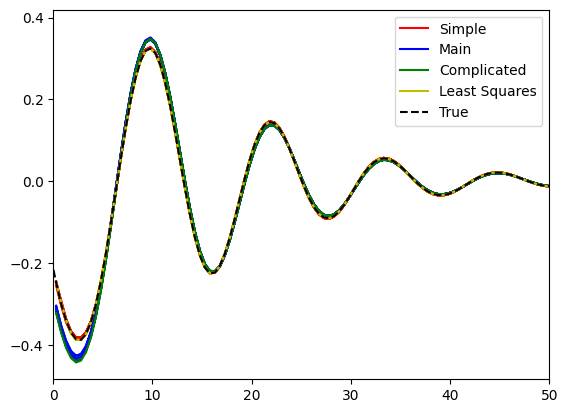

In [ ]:
num_samples, num_dim = samples.shape

num_draws = 10

indices = np.random.choice(np.arange(num_samples), size=num_draws, replace=False)

ell, m = (2, 2)
posterior_signals_c = np.zeros((num_draws, len(analysis_times)), dtype=complex)
posterior_signals = np.zeros((num_draws, len(analysis_times)), dtype=complex)
posterior_signals_s = np.zeros((num_draws, len(analysis_times)), dtype=complex)

posterior_signals_ls = np.zeros((num_draws, len(analysis_times)), dtype=complex)

for i, idx in enumerate(indices):
    posterior_signals_s[i] = qnm_model(
        analysis_times, t0, samples_s[idx], qnm_list, spherical_modes, Mf_0, chif_mag_0
    )[(ell, m)]
    posterior_signals[i] = qnm_model(
        analysis_times, t0, samples[idx], qnm_list, spherical_modes, Mf_0, chif_mag_0
    )[(ell, m)]
    posterior_signals_c[i] = qnm_model(
        analysis_times, t0, samples_c[idx], qnm_list, spherical_modes, Mf_0, chif_mag_0
    )[(ell, m)]
    posterior_signals_ls[i] = qnm_model(
        analysis_times, t0, true_params, qnm_list, spherical_modes, Mf_0, chif_mag_0
    )[(ell, m)]

    plt.plot(
        analysis_times,
        np.real(posterior_signals_s[i]),
        label="Simple" if i == 0 else None,
        color="r",
    )
    plt.plot(
        analysis_times,
        np.real(posterior_signals[i]),
        label="Main" if i == 0 else None,
        color="b",
    )
    plt.plot(
        analysis_times,
        np.real(posterior_signals_c[i]),
        label="Complicated" if i == 0 else None,
        color="g",
    )
    plt.plot(
        analysis_times,
        np.real(posterior_signals_ls[i]),
        label="Least Squares" if i == 0 else None,
        color="y",
    )

plt.plot(
    sim_main.times, np.real(sim_main.h[ell, m]), label="True", color="black", ls="--"
)

plt.xlim(0, 50)
plt.legend()
plt.show()

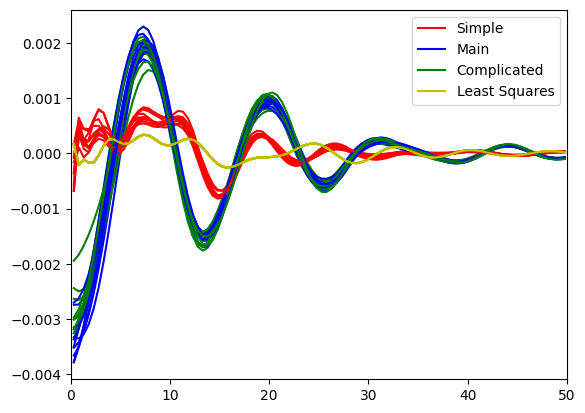

In [ ]:
num_samples, num_dim = samples.shape

num_draws = 10

indices = np.random.choice(np.arange(num_samples), size=num_draws, replace=False)

ell, m = (3, 2)
posterior_signals = np.zeros((num_draws, len(analysis_times)), dtype=complex)
posterior_signals_ = np.zeros((num_draws, len(analysis_times)), dtype=complex)

data = np.interp(analysis_times, sim_main.times, np.real(sim_main.h[ell, m]))

for i, idx in enumerate(indices):
    posterior_signals_s[i] = qnm_model(
        analysis_times, t0, samples_s[idx], qnm_list, spherical_modes, Mf_0, chif_mag_0
    )[(ell, m)]
    posterior_signals[i] = qnm_model(
        analysis_times, t0, samples[idx], qnm_list, spherical_modes, Mf_0, chif_mag_0
    )[(ell, m)]
    posterior_signals_c[i] = qnm_model(
        analysis_times, t0, samples_c[idx], qnm_list, spherical_modes, Mf_0, chif_mag_0
    )[(ell, m)]
    posterior_signals_ls[i] = qnm_model(
        analysis_times, t0, true_params, qnm_list, spherical_modes, Mf_0, chif_mag_0
    )[(ell, m)]

    plt.plot(
        analysis_times,
        data - np.real(posterior_signals_s[i]),
        label="Simple" if i == 0 else None,
        color="r",
    )
    plt.plot(
        analysis_times,
        data - np.real(posterior_signals[i]),
        label="Main" if i == 0 else None,
        color="b",
    )
    plt.plot(
        analysis_times,
        data - np.real(posterior_signals_c[i]),
        label="Complicated" if i == 0 else None,
        color="g",
    )
    plt.plot(
        analysis_times,
        data - np.real(posterior_signals_ls[i]),
        label="Least Squares" if i == 0 else None,
        color="y",
    )

plt.xlim(0, 50)
plt.legend()
plt.show()